In [ ]:
%%capture 
%pip install IPython
%pip install wordcloud 
%pip install multidict
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import multidict as multidict
import os
import re
import operator
import plotly.express as px
import seaborn as sns

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from IPython.display import HTML, display, Image

from PIL import Image
from nltk.corpus import stopwords
from os import path
from sklearn import metrics
from wordcloud import WordCloud
from collections import Counter
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
#Import dataset with stopwords removed
#GIULI
#train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progetto text mining/CSV/new_train2.csv')
#test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progetto text mining/CSV/new_test2.csv')

#FRA
train = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_train2.csv')
test = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_test2.csv')


In [ ]:
#Removing Nan from the dataset
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)
frames = [train, test]
df = pd.concat(frames, ignore_index = True)

# <h1><center><strong>$$\color{#4740BF}{\text{2. Supervised Machine Learning}}$$<strong></h3>


In this section of the project will be performed classification on the reviews. The algorithms used belong to the family of the supervised machine learning algorithm. These are algorithms that obtain input from the supervisor and learn from that input how to classify the text.
To achieve this aim the dataset has been divided into training and text and into x (review) and y (label).


### <h1><center><strong>$$\color{#4740BF}{\text{Linear SVC on 5 Lables}}$$<strong></h3>

In [ ]:
X_train = train['review']
X_test = test['review']
y_train = train['label']
y_test = test['label']

Then we built a pipelines to vectorize the data, then train and fit a model. We have used `TFIDF` (term frequency–inverse document frequency) that do vectorization assigning a value that increases depending on the importance of a token and it decreases depending on its frequency in the text (it penalizes popular terms). 
The algorithm used is Linear Support Vector Classification (SVC) that applies a linear kernel function to perform classification.


In [ ]:
# Linear Support Vector Classification:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

In [ ]:
%%time
text_clf_lsvc.fit(X_train, y_train)

CPU times: user 3min 57s, sys: 1.48 s, total: 3min 58s
Wall time: 3min 58s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

Now with the results of the Linear SVC we get the prediction on the test set and plot the Confusion Matrix:

In [ ]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [ ]:
# Report the confusion matrix
cf_matrix = metrics.confusion_matrix(y_test,predictions)
cf_matrix 

array([[7671, 1687,  321,  116,  204],
       [2758, 4466, 2008,  483,  285],
       [ 709, 2092, 4299, 2174,  726],
       [ 236,  461, 1938, 4371, 2994],
       [ 203,  169,  463, 2058, 7107]])

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)

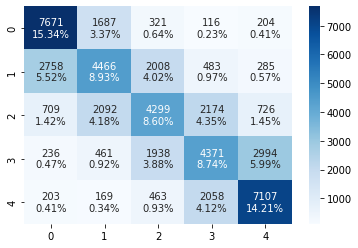

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
None

As it is possible to notice from the heat map the model perform well in predicting the categories 1 and 5 but has some difficulties in the categories in the middle that tend to be more accurate. Anyway the predictions seems to be quite accurate.

Looking at the chart below it is possible to observe some indices that allows us to evaluate the model. 

In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.66      0.77      0.71      9999
           2       0.50      0.45      0.47     10000
           3       0.48      0.43      0.45     10000
           4       0.48      0.44      0.46     10000
           5       0.63      0.71      0.67     10000

    accuracy                           0.56     49999
   macro avg       0.55      0.56      0.55     49999
weighted avg       0.55      0.56      0.55     49999



The whole accuracy of the model is 55.83% that is better than assign label by chance (because we have 5 classes). As it was predictable from the confusion matrix also the values of precision, recall and f1-score are higher for the external labels while they are all less or equal than 50% in the middle categories. 

In [ ]:
# Print the overall accuracy
print(round((metrics.accuracy_score(y_test,predictions))*100, 2), "%")

55.83 %



### <h1><center><strong>$$\color{#4740BF}{\text{Linear SVC on 3 Categories}}$$<strong></h3>

Based on these result we tried to run the same model but splitting the dataset into 3 categories that correspond to positive revies (label = 4 or 5), negative reviws (label = 1 or 2 ) and neutral reviws (label = 3). We expect that with this new categories the result would be better. 
We also balanced the new dataframe so that the numbers of positive, negative and neutral reviws are similar. To achieve this result we need to reduce the dimension of the training dataframe that now has shape (389988, 2). 

In [ ]:
train["cat"] = train["label"]
train["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del train["label"]
test["cat"] = test["label"]
test["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del test["label"]

#Balancing Train set
from sklearn.utils import shuffle
pos_train_subset = train[train["cat"]=="pos"].sample(n=len(train[train["cat"]=="neut"]),random_state=28)
neut_train_subset = train[train["cat"]=="neut"]
neg_train_subset = train[train["cat"]=="neg"].sample(n=len(train[train["cat"]=="neut"]),random_state=98)
print("pos", pos_train_subset.shape, "neut", neut_train_subset.shape, "neg",neg_train_subset.shape)
train_sub = shuffle(pd.concat([pos_train_subset, neut_train_subset, neg_train_subset], ignore_index = True))
train_sub.reset_index(drop=True, inplace=True)
train_sub.head()

pos (129996, 2) neut (129996, 2) neg (129996, 2)


,review,cat
0,restaurant overrated think stars fair rating f...,neut
1,lately not things ready stock tell want going ...,neut
2,went monday january 2014 groupon deal kind slo...,neut
3,vegas convention weekend came big group people...,neut
4,great day indoors instructor rob great calm pa...,pos


Now the whole procedure as before is applied on the new dataframe on the category `cat`

In [ ]:
X_train = train_sub['review']
X_test = test_sub['review']
y_train = train_sub['cat']
y_test = test_sub['cat']

In [ ]:
text_clf_lsvc.fit(X_train, y_train)
predictions = text_clf_lsvc.predict(X_test)

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test,predictions) 

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

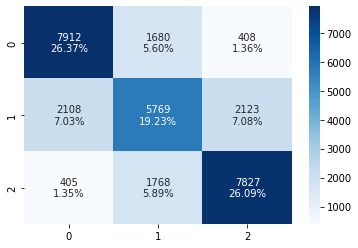

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
None

In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         neg       0.76      0.79      0.77     10000
        neut       0.63      0.58      0.60     10000
         pos       0.76      0.78      0.77     10000

    accuracy                           0.72     30000
   macro avg       0.71      0.72      0.71     30000
weighted avg       0.71      0.72      0.71     30000



In [ ]:
# Print the overall accuracy
print(round((metrics.accuracy_score(y_test,predictions))*100, 2), "%")

71.69 %


 
As it was predicted, the accuracy is increased in this case (71.69% compared to 55.83%).The algorithm is pretty good in predicting the 3 categories and it is really fast. As before the false positves and false negatives usually occur for "contiguos categories" ie the algorithm usually do not confuse negative and positive reviews but only negative and neutral or neutral and positive. 